Scale: 10, Sigma: 2.5937424601000023
Scale: 11, Sigma: 2.8531167061100025
Scale: 12, Sigma: 3.138428376721003
Scale: 13, Sigma: 3.452271214393104
Scale: 14, Sigma: 3.7974983358324144
Scale: 15, Sigma: 4.177248169415656
Scale: 16, Sigma: 4.594972986357222
Scale: 17, Sigma: 5.054470284992945
Scale: 18, Sigma: 5.55991731349224
Scale: 19, Sigma: 6.115909044841464
Scale: 20, Sigma: 6.727499949325611
Scale: 21, Sigma: 7.400249944258173
Scale: 22, Sigma: 8.14027493868399
Scale: 23, Sigma: 8.95430243255239
Scale: 24, Sigma: 9.84973267580763
Scale: 25, Sigma: 10.834705943388395
Parameters of the largest circle: X = 53, Y = 175, Radius = 15


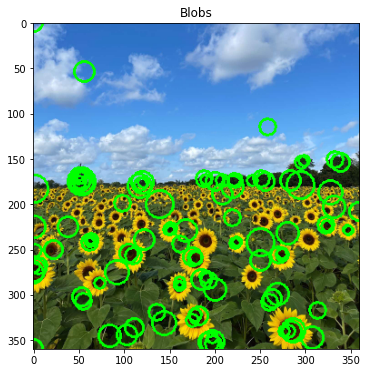

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'the_berry_farms_sunflower_field.jpeg'
im = cv2.imread(image_path, cv2.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Set the scale-space parameters
min_radius = 2
max_radius = 1000
sigma_step = 1.1  # Sigma multiplication factor
num_scales_min = 10  # Number of scales
num_scales_max = 26  # Number of scales
min_desired_radius = 5  # Minimum desired radius
overlap_thresh = 0.3  # Non-maximum suppression threshold
distance_thresh = 50  # Distance threshold to consider circles separate

# Initialize a list to store circle parameters
all_circles = []

# Apply LoG for scale-space extrema detection
for scale in range(num_scales_min, num_scales_max):
    sigma = (sigma_step ** scale)
    print(f"Scale: {scale}, Sigma: {sigma}")

    blurred = cv2.GaussianBlur(gray, (0, 0), sigma)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
    response = sigma ** 2 * laplacian

    # Threshold the response to find local maxima
    _, thresh = cv2.threshold(response, 0.8 * response.max(), 255, cv2.THRESH_BINARY)

    # Find local maxima as potential circles
    local_maxima = (thresh == 255).astype(np.uint8)

    # Extract circle centers and radii
    y, x = np.where(local_maxima)
    radii = np.full_like(x, sigma * np.sqrt(2))
    circles = list(zip(x, y, radii))

    # Apply non-maximum suppression to circles within each scale
    def non_max_suppression(circles, overlap_thresh=0.3, distance_thresh=25):
        # Sort circles by radii in descending order
        circles = sorted(circles, key=lambda x: x[2], reverse=True)

        # Initialize list to store final circles
        final_circles = []

        for circle in circles:
            # Check if the circle has sufficient distance from existing circles within a local area
            local_circles = [c for c in final_circles if np.linalg.norm(np.array([circle[0], circle[1]]) - np.array([c[0], c[1]])) <= distance_thresh]
            if not any(np.linalg.norm(np.array([circle[0], circle[1]]) - np.array([cx, cy])) < distance_thresh for cx, cy, _ in local_circles):
                final_circles.append(circle)

        return final_circles

    # Apply non-maximum suppression to circles within each scale
    circles1 = non_max_suppression(circles, overlap_thresh, distance_thresh)
    all_circles.extend(circles1)

# Filter out circles with radii below the threshold
final_circles = [(x, y, r) for x, y, r in all_circles if r >= min_desired_radius]

# Sort circles by radii in descending order
final_circles = sorted(final_circles, key=lambda x: x[2], reverse=True)

# Report the parameters of the largest circles
if final_circles:
    largest_circle = final_circles[0]
    print(f"Parameters of the largest circle: X = {largest_circle[0]}, Y = {largest_circle[1]}, Radius = {largest_circle[2]}")
else:
    print("No circles found.")
    
# Draw circles on the image
for x, y, r in final_circles:
    cv2.circle(im, (x, y), int(r), (0, 255, 0), 2)

# Display the result using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title(f"Blobs")
plt.show()
